In [8]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import os
import sys
sys.path.insert(0, '..')


import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from PIL import Image
torch.manual_seed(42)



## load data

In [75]:
label_df = pd.read_csv('load_data/Target-test.csv')

In [76]:
label_df = label_df.sort_values(by=['Description', 'Quote_Start_Date']).reset_index(drop=True)
label_df.to_csv('load_data/Target-test.csv')

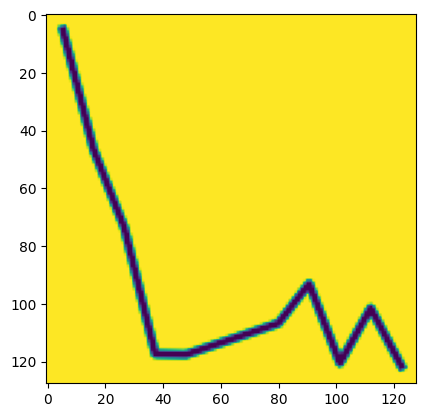

In [74]:
plt.imshow(images[0])

In [62]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

# Function to load and process images
def load_and_process_images(image_dir):
    images_list = sorted(os.listdir(image_dir))
    processed_images = []

    for image_filename in tqdm(images_list):
        try:
            image_path = os.path.join(image_dir, image_filename)
            image = Image.open(image_path)

            # Convert the image to a NumPy array
            image_array = np.array(image)

            # Check if the array has a third dimension
            if image_array.shape == (128,128,4):
                # If the image has 4 channels, take the mean along the third dimension
                image_array = np.mean(image_array, axis=2, dtype=np.uint8)

            processed_images.append(image_array)
        except:
            pass
    return processed_images

# Example usage
image_directory = 'imgs/10p5-test'
processed_images = load_and_process_images(image_directory)


100%|█████████████████████████████████████| 7911/7911 [00:02<00:00, 3856.47it/s]


In [63]:
images = np.array(processed_images)

In [64]:
np.save('load_data/images_array-test.npy', images)

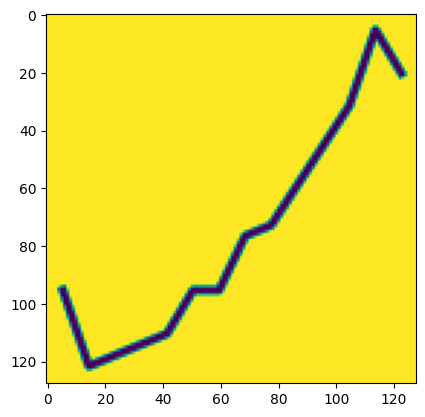

In [69]:
import matplotlib.pyplot as plt 
plt.imshow(images[-1])

## build dataset

In [4]:
class MyDataset(Dataset):
    
    def __init__(self, img, label):
        self.img = torch.Tensor(img.copy())
        self.label = torch.Tensor(label)
        self.len = len(img)
  
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.img[idx], self.label[idx]
    
dataset = MyDataset(images, label_df.Label.values)
test_dataloader = DataLoader(dataset, batch_size=2048, shuffle=False)

# the neural network

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(5, 3), stride=(3, 1), dilation=(2, 1), padding=(12, 1)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(5, 3), stride=(3, 1), dilation=(2, 1), padding=(12, 1)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=(5, 3), stride=(3, 1), dilation=(2, 1), padding=(12, 1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.fc1 = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(131072, 2),
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
#         print("Input size:", x.size())
        x = x.reshape(-1, 1, 128, 128)
        x = self.layer1(x)
#         print("After layer1 size:", x.size())
        x = self.layer2(x)
#         print("After layer2 size:", x.size())
        x = self.layer3(x)
#         print("After layer3 size:", x.size())
        x = x.view(x.size(0), -1)  # Flatten before the linear layer
#         print("After flattening size:", x.size())
        x = self.fc1(x)
#         print("After fc1 size:", x.size(), x)
        x = self.softmax(x)
#         print("After soft size:", x.size(), x)
        return x

## test

In [9]:
net_path = './CNN/baseline_epoch_11_train_0.663015_val_0.646687.pt'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load pre-trained model
net = torch.load(net_path)

target = []
predict = []

def eval_loop(dataloader, net, loss_fn):
    
    running_loss = 0.0
    total_loss = 0.0
    current = 0
    net.eval()
    target = []
    predict = []
    with torch.no_grad():
        with tqdm(dataloader) as t:
            for batch, (X, y) in enumerate(t):
                X = X.to(device)
                y = y.to(device)
                
                y = [[0, 1] if i == 1 else [1, 0] for i in y]
                y = torch.tensor(y)
                y = y.to(torch.float32)
                    
                y = y.to(device)
                
                y_pred = net(X)
                target.append(y.detach())
                predict.append(y_pred.detach())
                loss = loss_fn(y_pred, y)
                
                running_loss = (len(X) * loss.item() + running_loss * current) / (len(X) + current)
                current += len(X)
                t.set_postfix({'running_loss':running_loss})
            
    return total_loss, torch.cat(predict), torch.cat(target)

In [10]:
# Get current time for creating unique file names
start_time = datetime.datetime.now().strftime('%Y%m%d_%H:%M:%S')

# Loss function
loss_fn = torch.nn.BCELoss()

# Evaluate the model on the test set
test_loss, y_pred, y_target = eval_loop(test_dataloader, net, loss_fn)

# Convert logits to probabilities and save to CSV
predict_logit = y_pred[:, 1].cpu().numpy()
logit_output = pd.Series(predict_logit)
logit_output.to_csv('./CNN/logits/' + f'logits_{start_time}.csv')

  0%|                                                                        | 0/45 [00:00<?, ?it/s]


RuntimeError: module must have its parameters and buffers on device cuda:0 (device_ids[0]) but found one of them on device: cpu